In [1]:
import matplotlib
matplotlib.use('TkAgg')

import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import random
import dynetx as dn

from general_graph_utils import *

# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif")
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

**Goals of simulation**

* Initialize a system of N particles in finite space
* Each particle assigned a speed v and direction of motion r
* Each particle exists in one of two states:
    * "Run" state: particle moves in a straight line forming a polymer link with finite probability => adds an edge
    * "Tumble" state: particle changes direction => adds a node
   

**Without merge**

Step 0: Plotting network...


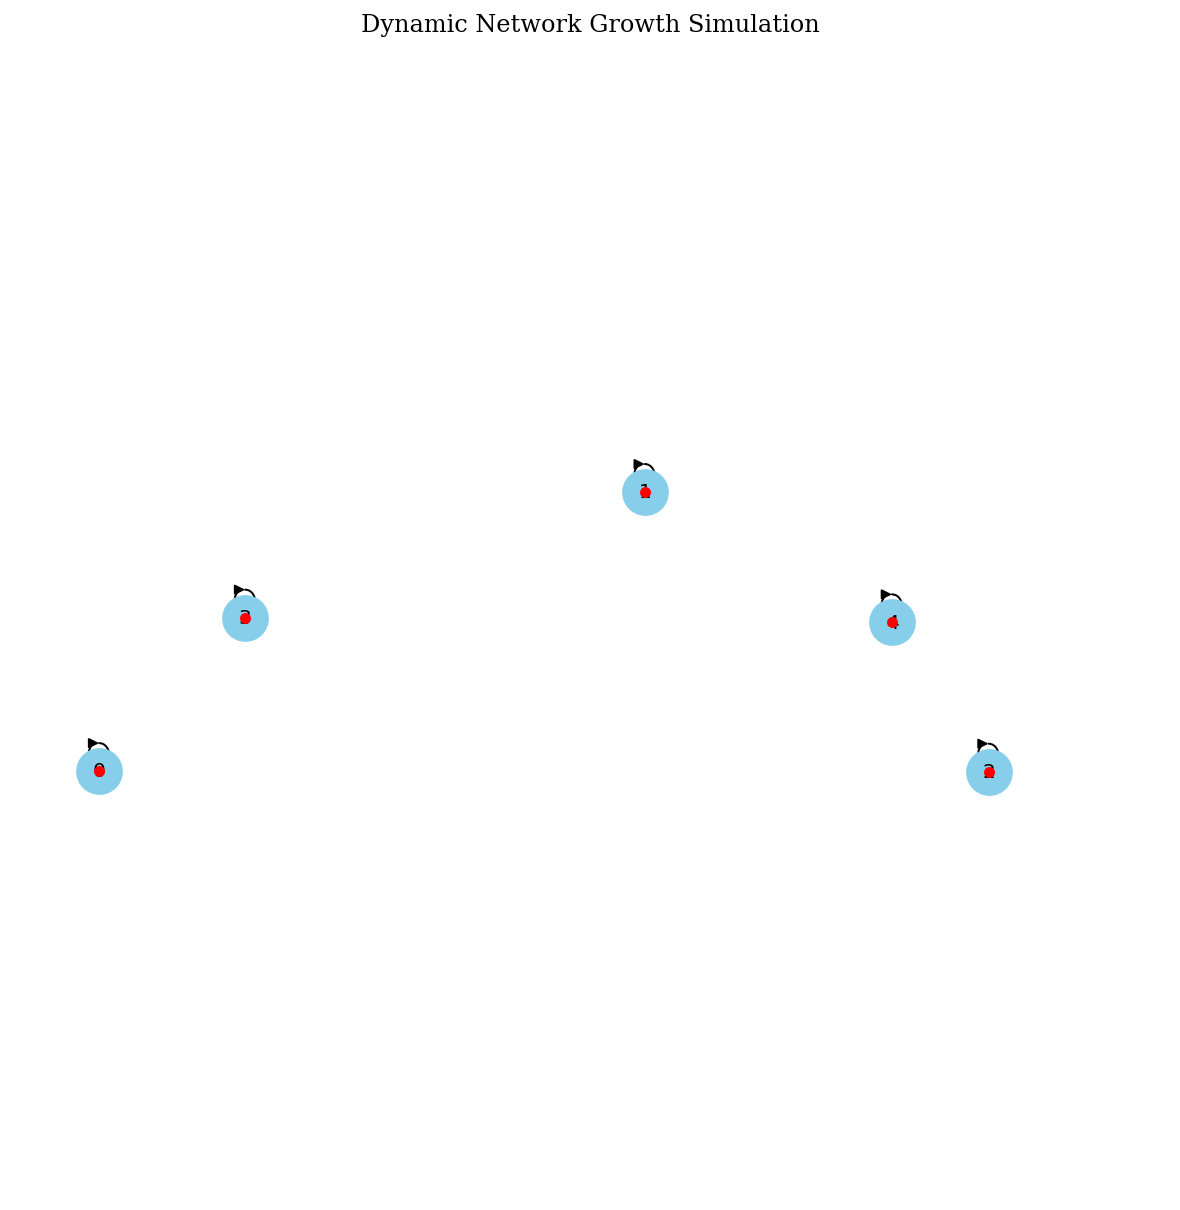

Step 5: Plotting network...


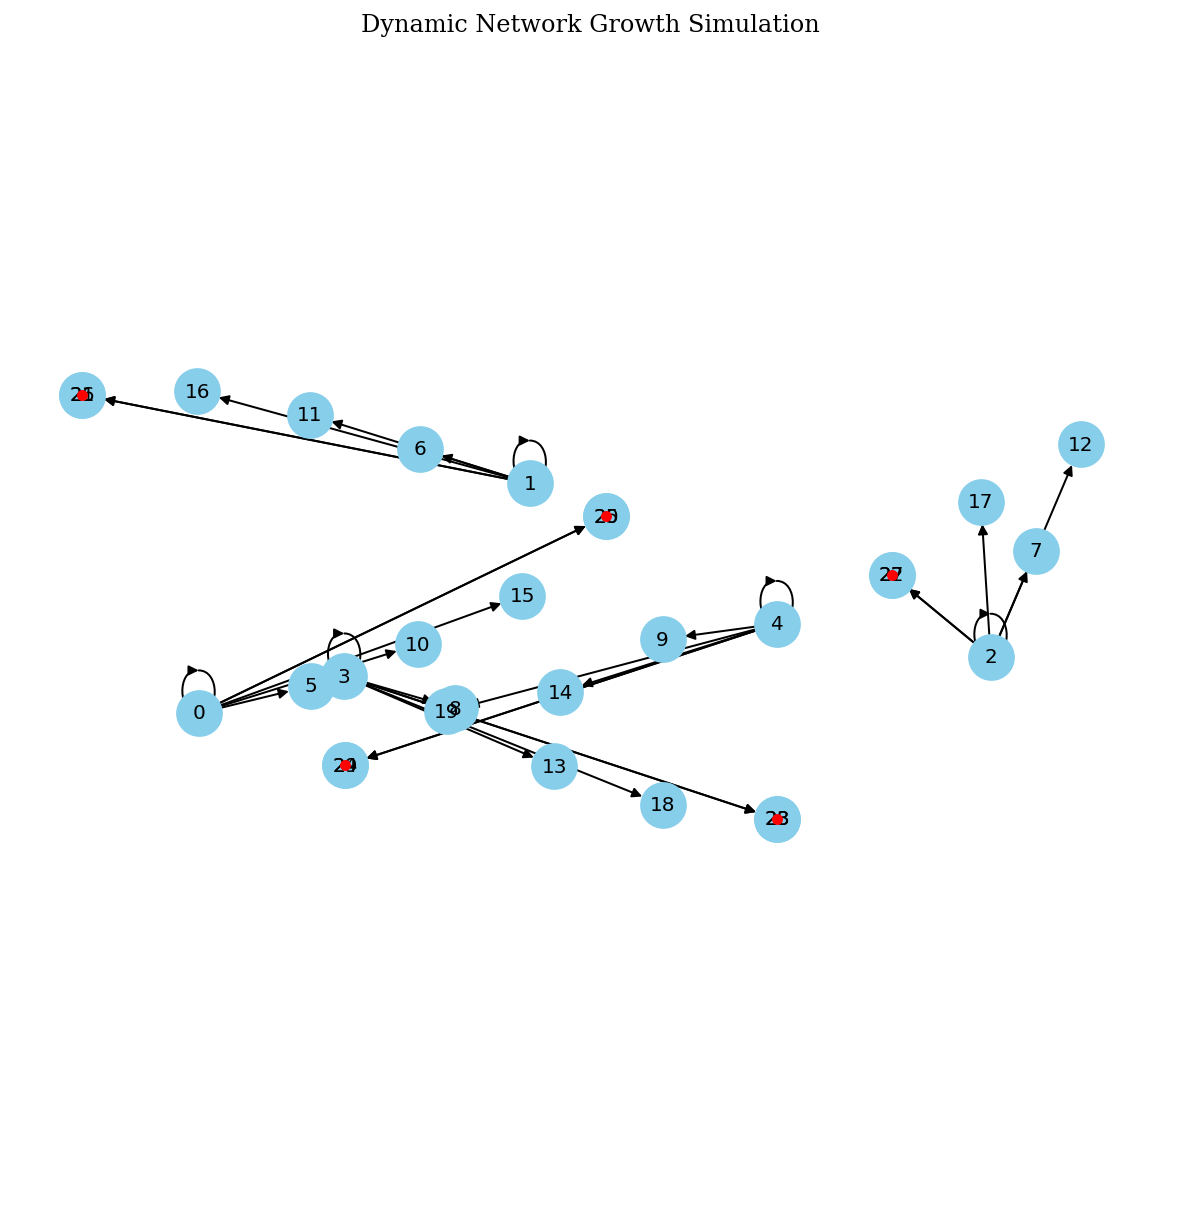

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx

# Parameters
N = 5  # Number of particles
v = 0.1  # Speed of particles
space_size = 1.0  # Size of the 2D space
tumble_rate = 0.05  # Rate of transitioning to the tumble state (higher = more frequent tumbling)
run_prob = 0.5  # Probability of forming an edge when in "run" state
max_time_steps = 10  # Maximum time steps for the simulation

# Initialize the graph (DiGraph)
G = nx.DiGraph()

# Particle properties: position (x, y), direction (radians), state (run/tumble), and previous position
particles = []
for i in range(N):
    x, y = np.random.rand(2) * space_size
    angle = np.random.rand() * 2 * np.pi  # Random initial direction
    state = "run" if random.random() < 0.5 else "tumble"  # Random initial state
    particles.append({
        'pos': np.array([x, y]),  # Position of the particle
        'prev_pos': np.array([x, y]),  # Previous position of the particle
        'angle': angle,           # Direction of movement (angle in radians)
        'state': state            # State: "run" or "tumble"
    })

# Function to update the graph by adding edges between particles
def update_graph(G, particles):
    for i, p in enumerate(particles):
        prev_pos = p['prev_pos']
        curr_pos = p['pos']
        
        # Check if the particle has moved (compare positions as scalars, not arrays)
        if not np.array_equal(curr_pos, prev_pos):  # This checks if positions are not equal
            # Create a new node for the current position of the particle
            node_id = len(G.nodes())  # New node ID based on graph size
            G.add_node(node_id, pos=curr_pos, time=i)  # Set the node position explicitly
            # Add an edge from the particle's previous position to the new position
            G.add_edge(i, node_id)  # Add an edge from the particle to its current position
        
        # **Update previous position here** after the edge is created
        p['prev_pos'] = np.copy(p['pos'])

# Function to update the state and position of particles
def update_particles(particles, tumble_rate, v, space_size):
    for p in particles:
        # Transition probability to "tumble" state
        if p['state'] == "run" and random.random() < tumble_rate:
            p['state'] = "tumble"
        
        # Transition probability to "run" state (based on local density, simplified here)
        elif p['state'] == "tumble" and random.random() < tumble_rate:
            p['state'] = "run"
        
        # Update the direction (angle) for each particle
        p['angle'] += np.random.uniform(-np.pi/8, np.pi/8)  # Small random change in angle for every iteration
        p['angle'] = np.mod(p['angle'], 2*np.pi)  # Ensure the angle is between 0 and 2*pi

        # Boundary avoidance behavior: More dramatic angle change if near boundary
        boundary_threshold = 0.1 * space_size  # 10% of space size

        # If the particle is near any boundary, apply a dramatic angle change
        if np.any(p['pos'] < boundary_threshold) or np.any(p['pos'] > (space_size - boundary_threshold)):
            # Apply a larger angle change if near boundary (steer away)
            p['angle'] += np.random.uniform(np.pi/2, np.pi)  # Rotate by a large random amount to steer away
            p['angle'] = np.mod(p['angle'], 2*np.pi)  # Ensure the angle is within the valid range
        
        # Update the position of the particle based on its current state
        if p['state'] == "run":
            # Move in the current direction
            p['pos'] += v * np.array([np.cos(p['angle']), np.sin(p['angle'])])
        elif p['state'] == "tumble":
            # Randomly change direction (tumble)
            p['pos'] += v * np.array([np.cos(p['angle']), np.sin(p['angle'])])

        # Clip the position to ensure it stays within bounds
        p['pos'] = np.clip(p['pos'], 0, space_size)  # Keep the particle within the confined space

        # Debugging: Check if particle is going out of bounds
        if np.any(p['pos'] < 0) or np.any(p['pos'] > space_size):
            print(f"Warning: Particle {p} is out of bounds! Clipped position: {p['pos']}")

# Visualization function
def plot_network(G, particles, space_size):
    # Get positions of nodes from dynamic graph
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    
    plt.figure(figsize=(8, 8))
    
    # Draw graph (edges and nodes)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10)

    # Plot the particles as points
    particle_positions = [p['pos'] for p in particles]
    particle_positions = np.array(particle_positions)
    plt.scatter(particle_positions[:, 0], particle_positions[:, 1], color="red", s=20, zorder=5)
    
    # Set plot limits and labels
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)
    plt.title("Dynamic Network Growth Simulation")
    plt.show()

# Simulation loop
for t in range(max_time_steps):
    # Update particles and graph
    update_particles(particles, tumble_rate, v, space_size)
    update_graph(G, particles)
    
    # Every 5 steps, plot the network
    if t % 5 == 0:
        print(f"Step {t}: Plotting network...")
        plot_network(G, particles, space_size)

**With merge**

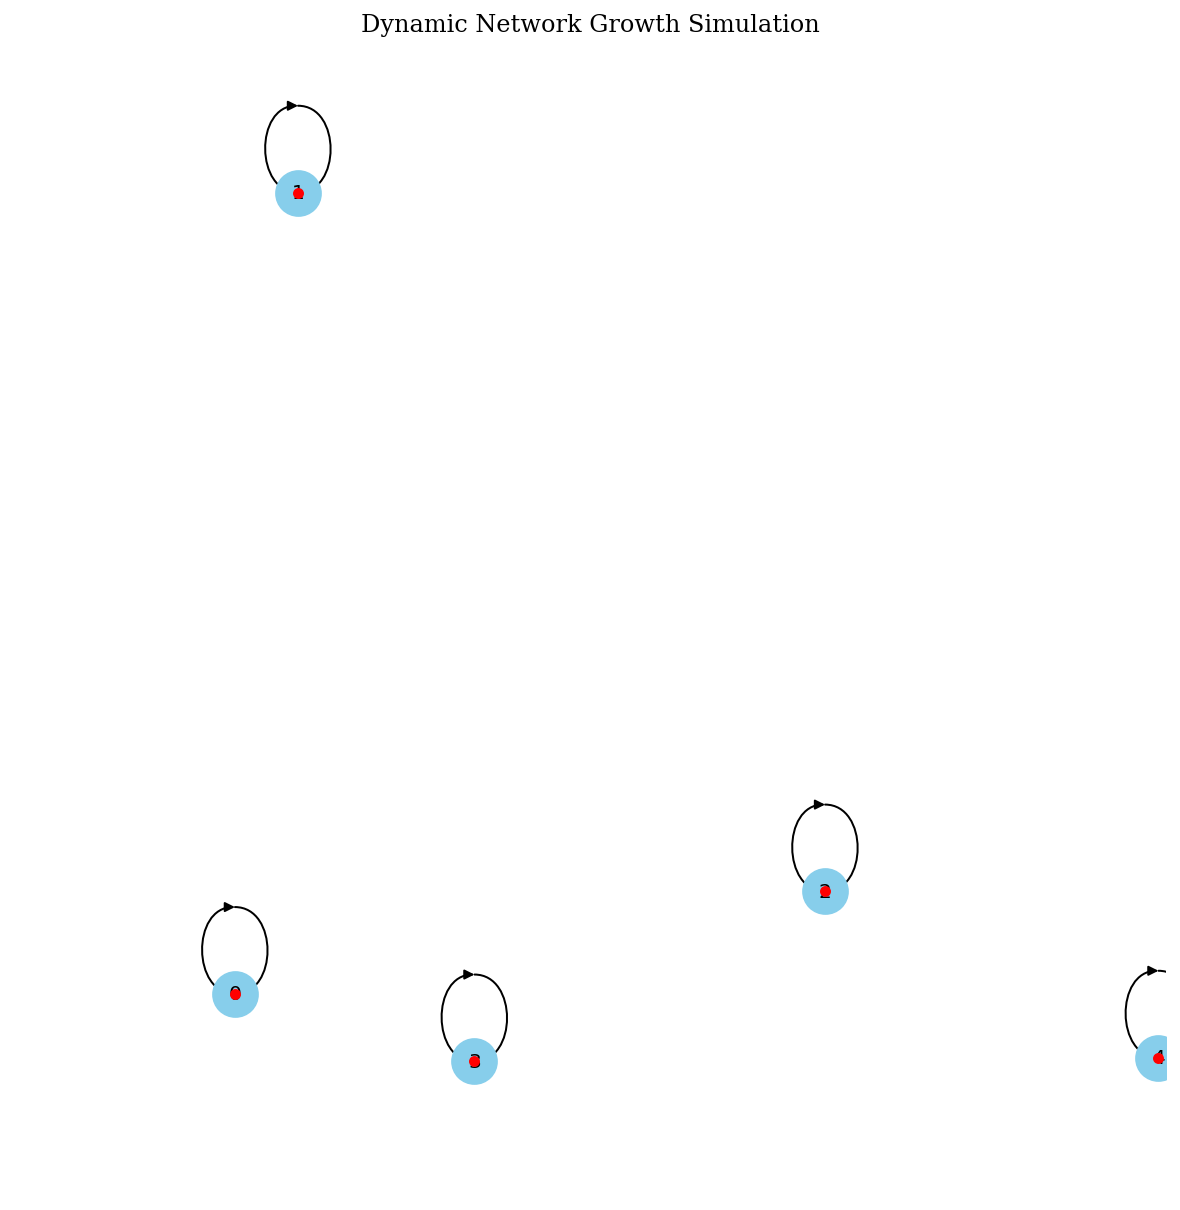

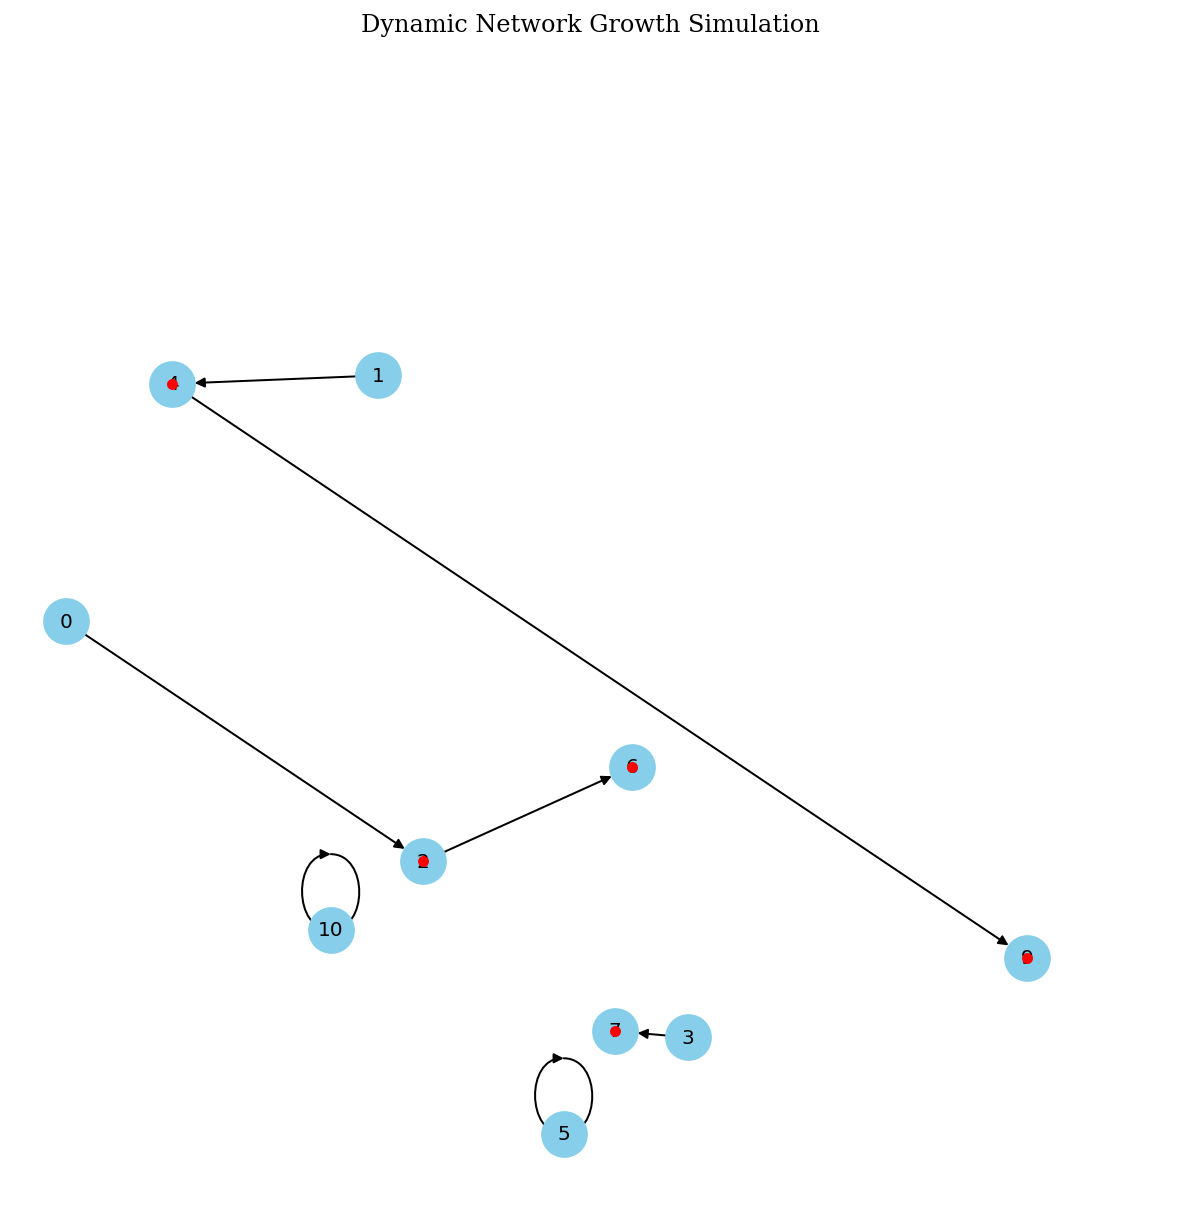

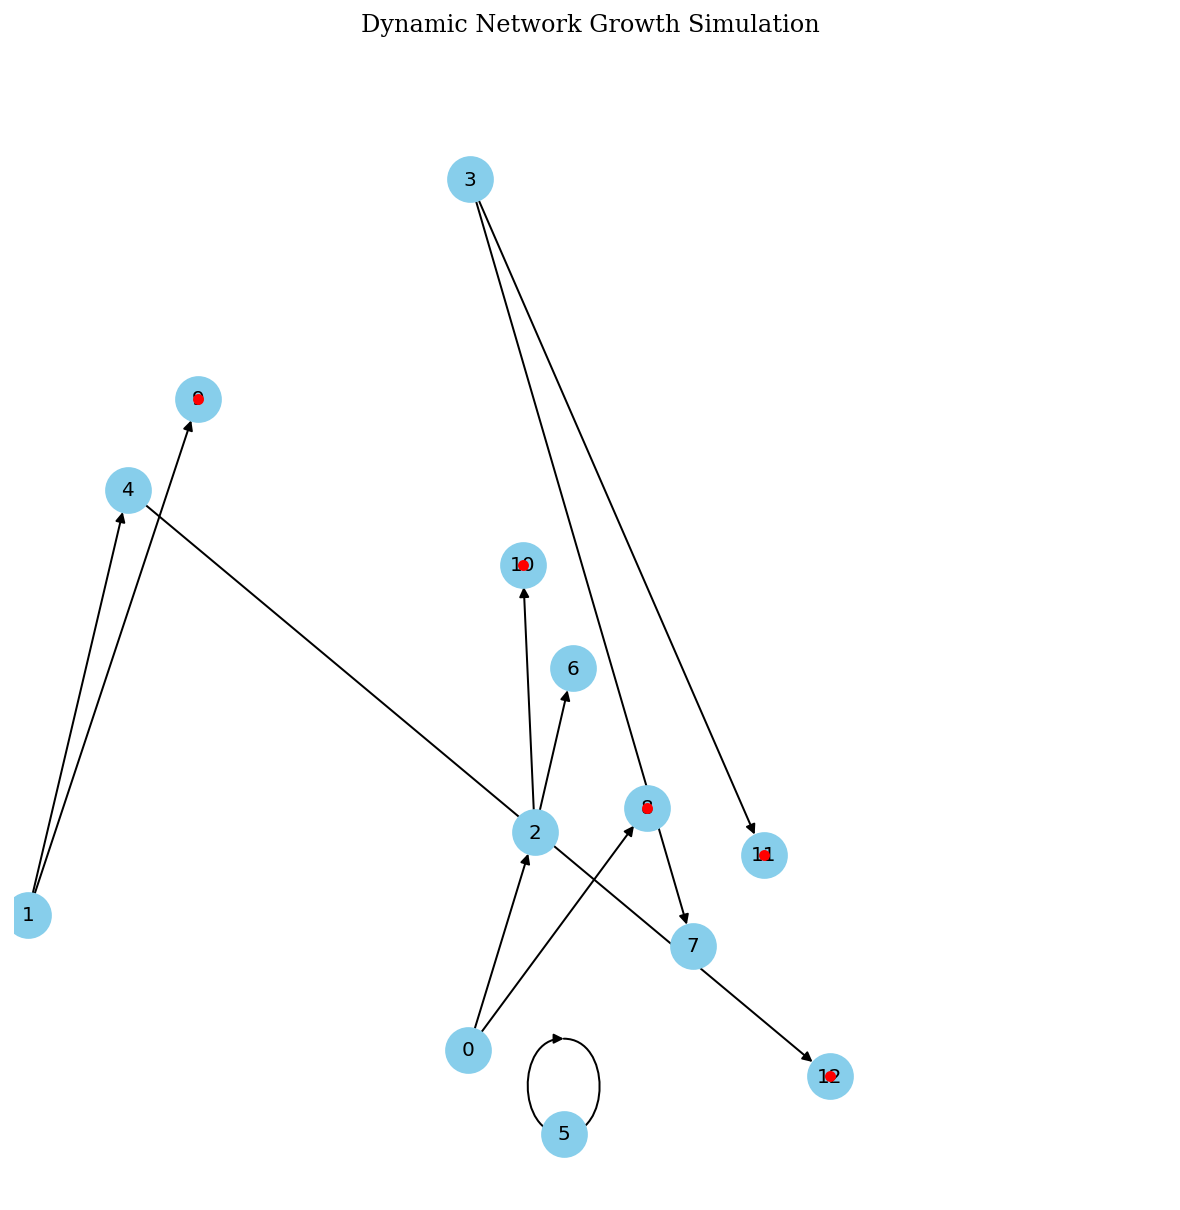

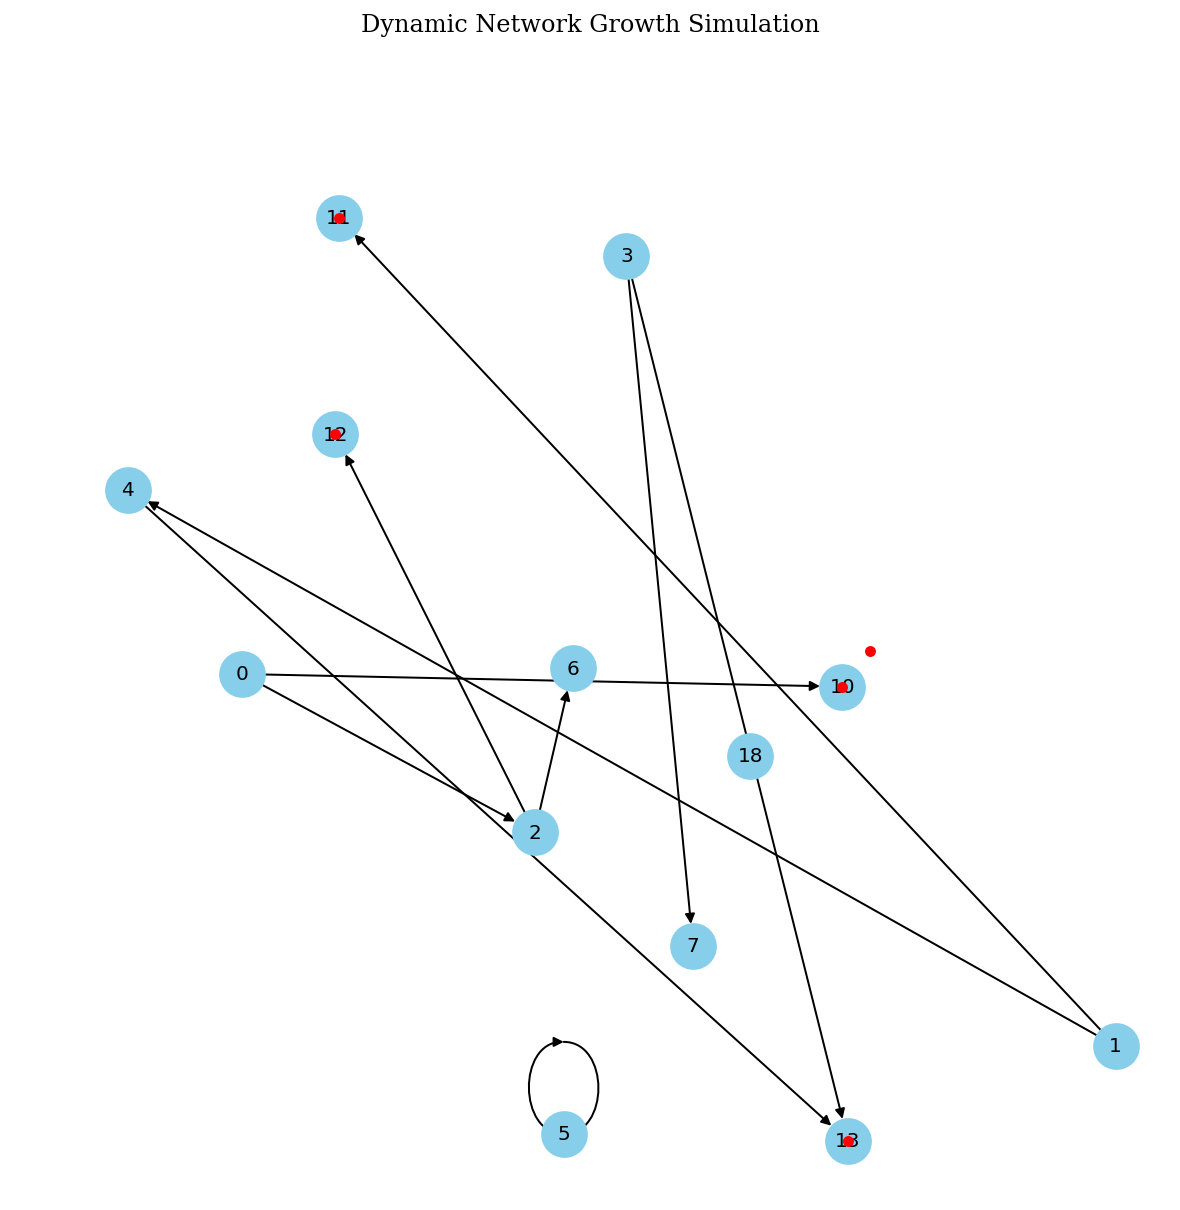

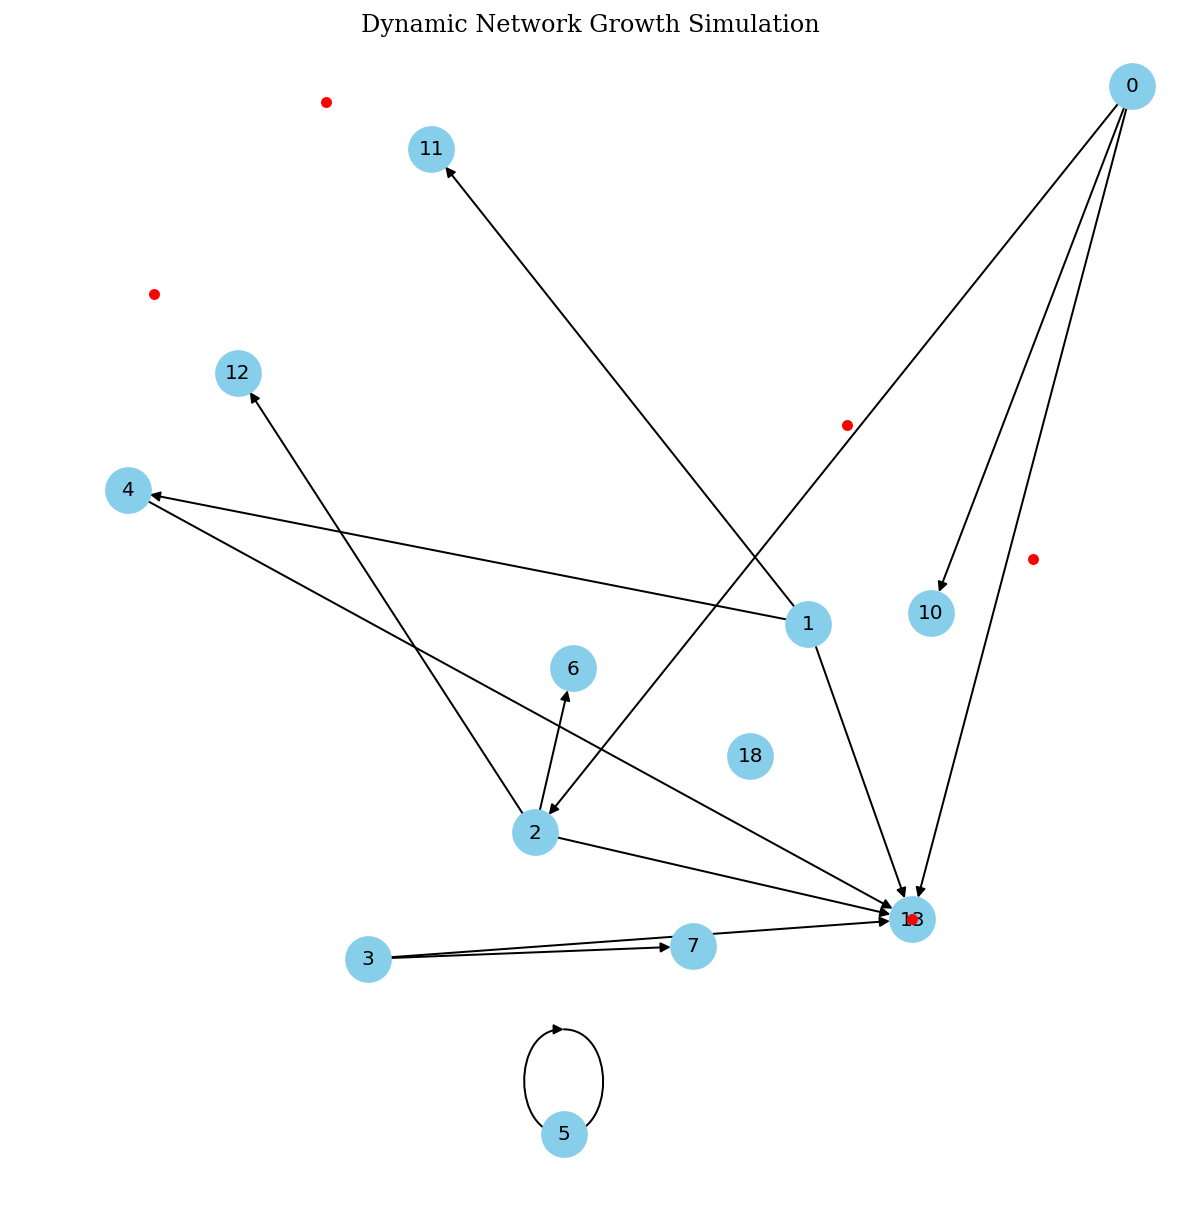

In [103]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

# Parameters
N = 5  # Number of particles
v = 0.1  # Speed of particles
space_size = 1.0  # Size of the 2D space
tumble_rate = 0.05  # Rate of transitioning to the tumble state (higher = more frequent tumbling)
run_prob = 0.5  # Probability of forming an edge when in "run" state
max_time_steps = 10  # Maximum time steps for the simulation
merge_threshold = 0.05  # Threshold distance for merging nodes

# Initialize the graph (DiGraph)
G = nx.DiGraph()

# Particle properties: position (x, y), direction (radians), state (run/tumble), and previous position
particles = []
for i in range(N):
    x, y = np.random.rand(2) * space_size
    angle = np.random.rand() * 2 * np.pi  # Random initial direction
    state = "run" if random.random() < 0.5 else "tumble"  # Random initial state
    particles.append({
        'pos': np.array([x, y]),  # Position of the particle
        'prev_pos': np.array([x, y]),  # Previous position of the particle
        'angle': angle,           # Direction of movement (angle in radians)
        'state': state            # State: "run" or "tumble"
    })

# Function to update the graph by adding edges between particles
def update_graph(G, particles):
    for i, p in enumerate(particles):
        prev_pos = p['prev_pos']
        curr_pos = p['pos']
        
        # Check if the particle has moved (compare positions as scalars, not arrays)
        if not np.array_equal(curr_pos, prev_pos):  # This checks if positions are not equal
            node_id = len(G.nodes())  # New node ID based on graph size
            
            # Add the node with 'pos' attribute set correctly
            G.add_node(node_id, pos=curr_pos, time=i)  # Explicitly set the position attribute
            
            # Add an edge from the particle's previous position to the new position
            G.add_edge(i, node_id)  # Add an edge from the particle to its current position
        
        # Update previous position here after the edge is created
        p['prev_pos'] = np.copy(p['pos'])

# Simplified merge function: Merge nodes that are within the threshold distance
def merge_nearby_nodes(G, merge_threshold, space_size):
    # Collect all node positions
    positions = {node: data['pos'] for node, data in G.nodes(data=True) if 'pos' in data}
    
    # Find pairs of nodes that are within the merge threshold
    nodes_to_merge = []
    for node1, pos1 in positions.items():
        for node2, pos2 in positions.items():
            if node1 < node2:  # Avoid comparing the same node to itself
                dist = np.linalg.norm(pos1 - pos2)
                if dist < merge_threshold:
                    nodes_to_merge.append((node1, node2))
    
    # Merge nodes by creating a new node at the average position
    merged_nodes = set()
    for node1, node2 in nodes_to_merge:
        if node1 not in merged_nodes and node2 not in merged_nodes:
            # Calculate the new position (average of the two positions)
            new_pos = (positions[node1] + positions[node2]) / 2.0
            
            # Clip the new position to stay within the bounds of the space
            new_pos = np.clip(new_pos, 0, space_size)
            
            new_node_id = len(G.nodes())  # New node ID
            
            # Create the new merged node and assign the position explicitly
            G.add_node(new_node_id, pos=new_pos)
            
            # Redirect all edges from node1 and node2 to the new node
            for neighbor in list(G.neighbors(node1)):
                G.add_edge(neighbor, new_node_id)
            for neighbor in list(G.neighbors(node2)):
                G.add_edge(neighbor, new_node_id)
            
            # Remove old nodes from the graph
            G.remove_node(node1)
            G.remove_node(node2)
            
            # Mark nodes as merged
            merged_nodes.add(node1)
            merged_nodes.add(node2)

# Function to update the state and position of particles
def update_particles(particles, tumble_rate, v, space_size):
    for p in particles:
        # Transition probability to "tumble" state
        if p['state'] == "run" and random.random() < tumble_rate:
            p['state'] = "tumble"
        
        # Transition probability to "run" state (based on local density, simplified here)
        elif p['state'] == "tumble" and random.random() < tumble_rate:
            p['state'] = "run"
        
        # Update the direction (angle) for each particle
        p['angle'] += np.random.uniform(-np.pi/8, np.pi/8)  # Small random change in angle for every iteration
        p['angle'] = np.mod(p['angle'], 2*np.pi)  # Ensure the angle is between 0 and 2*pi

        # Boundary avoidance behavior: More dramatic angle change if near boundary
        boundary_threshold = 0.1 * space_size  # 10% of space size

        # If the particle is near any boundary, apply a dramatic angle change
        if np.any(p['pos'] < boundary_threshold) or np.any(p['pos'] > (space_size - boundary_threshold)):
            # Apply a larger angle change if near boundary (steer away)
            p['angle'] += np.random.uniform(np.pi/2, np.pi)  # Rotate by a large random amount to steer away
            p['angle'] = np.mod(p['angle'], 2*np.pi)  # Ensure the angle is within the valid range
        
        # Update the position of the particle based on its current state
        if p['state'] == "run":
            # Move in the current direction
            p['pos'] += v * np.array([np.cos(p['angle']), np.sin(p['angle'])])
        elif p['state'] == "tumble":
            # Randomly change direction (tumble)
            p['pos'] += v * np.array([np.cos(p['angle']), np.sin(p['angle'])])

        # Clip the position to ensure it stays within bounds
        p['pos'] = np.clip(p['pos'], 0, space_size)  # Keep the particle within the confined space

# Visualization function
def plot_network(G, particles, space_size):
    # Get positions of nodes from dynamic graph
    pos = {}
    
    # Ensure all nodes have a 'pos' attribute before plotting
    for node, data in G.nodes(data=True):
        if 'pos' in data:
            pos[node] = data['pos']
        else:
            # Set a default position if a node doesn't have a 'pos' attribute
            pos[node] = np.array([random.random() * space_size, random.random() * space_size])

    plt.figure(figsize=(8, 8))
    
    # Draw graph (edges and nodes)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10)

    # Plot the particles as points
    particle_positions = [p['pos'] for p in particles]
    particle_positions = np.array(particle_positions)
    plt.scatter(particle_positions[:, 0], particle_positions[:, 1], color="red", s=20, zorder=5)
    
    # Set plot limits and labels
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)
    plt.title("Dynamic Network Growth Simulation")
    plt.show()

# Simulation loop
for t in range(max_time_steps):
    # Update particles and graph
    update_particles(particles, tumble_rate, v, space_size)
    update_graph(G, particles)
    merge_nearby_nodes(G, merge_threshold, space_size)
    
    # Every 5 steps, plot the network
    if t % 2 == 0:
        plot_network(G, particles, space_size)

**Animation**

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation

# Parameters (as before)
N = 5  # Number of particles
v = 0.1  # Speed of particles
space_size = 1.0  # Size of the 2D space
tumble_rate = 0.05  # Rate of transitioning to the tumble state
run_prob = 0.5  # Probability of forming an edge when in "run" state
max_time_steps = 10  # Maximum time steps for the simulation
merge_threshold = 0.05  # Threshold distance for merging nodes

# Initialize the graph (DiGraph)
G = nx.DiGraph()

# Particle properties (initial positions, directions, and states)
particles = []
for i in range(N):
    x, y = np.random.rand(2) * space_size
    angle = np.random.rand() * 2 * np.pi  # Random initial direction
    state = "run" if random.random() < 0.5 else "tumble"  # Random initial state
    particles.append({
        'pos': np.array([x, y]),  # Position of the particle
        'prev_pos': np.array([x, y]),  # Previous position of the particle
        'angle': angle,           # Direction of movement (angle in radians)
        'state': state            # State: "run" or "tumble"
    })

# Function to update the graph by adding edges between particles
def update_graph(G, particles):
    for i, p in enumerate(particles):
        prev_pos = p['prev_pos']
        curr_pos = p['pos']
        
        # Check if the particle has moved (compare positions as scalars, not arrays)
        if not np.array_equal(curr_pos, prev_pos):  # This checks if positions are not equal
            node_id = len(G.nodes())  # New node ID based on graph size
            
            # Add the node with 'pos' attribute set correctly
            G.add_node(node_id, pos=curr_pos, time=i)  # Explicitly set the position attribute
            
            # Add an edge from the particle's previous position to the new position
            G.add_edge(i, node_id)  # Add an edge from the particle to its current position
        
        # Update previous position here after the edge is created
        p['prev_pos'] = np.copy(p['pos'])

# Simplified merge function: Merge nodes that are within the threshold distance
def merge_nearby_nodes(G, merge_threshold, space_size):
    # Collect all node positions
    positions = {node: data['pos'] for node, data in G.nodes(data=True) if 'pos' in data}
    
    # Find pairs of nodes that are within the merge threshold
    nodes_to_merge = []
    for node1, pos1 in positions.items():
        for node2, pos2 in positions.items():
            if node1 < node2:  # Avoid comparing the same node to itself
                dist = np.linalg.norm(pos1 - pos2)
                if dist < merge_threshold:
                    nodes_to_merge.append((node1, node2))
    
    # Merge nodes by creating a new node at the average position
    merged_nodes = set()
    for node1, node2 in nodes_to_merge:
        if node1 not in merged_nodes and node2 not in merged_nodes:
            # Calculate the new position (average of the two positions)
            new_pos = (positions[node1] + positions[node2]) / 2.0
            
            # Clip the new position to stay within the bounds of the space
            new_pos = np.clip(new_pos, 0, space_size)
            
            new_node_id = len(G.nodes())  # New node ID
            
            # Create the new merged node and assign the position explicitly
            G.add_node(new_node_id, pos=new_pos)
            
            # Redirect all edges from node1 and node2 to the new node
            for neighbor in list(G.neighbors(node1)):
                G.add_edge(neighbor, new_node_id)
            for neighbor in list(G.neighbors(node2)):
                G.add_edge(neighbor, new_node_id)
            
            # Remove old nodes from the graph
            G.remove_node(node1)
            G.remove_node(node2)
            
            # Mark nodes as merged
            merged_nodes.add(node1)
            merged_nodes.add(node2)

# Function to update the state and position of particles
def update_particles(particles, tumble_rate, v, space_size):
    for p in particles:
        # Transition probability to "tumble" state
        if p['state'] == "run" and random.random() < tumble_rate:
            p['state'] = "tumble"
        
        # Transition probability to "run" state (based on local density, simplified here)
        elif p['state'] == "tumble" and random.random() < tumble_rate:
            p['state'] = "run"
        
        # Update the direction (angle) for each particle
        p['angle'] += np.random.uniform(-np.pi/8, np.pi/8)  # Small random change in angle for every iteration
        p['angle'] = np.mod(p['angle'], 2*np.pi)  # Ensure the angle is between 0 and 2*pi

        # Boundary avoidance behavior: More dramatic angle change if near boundary
        boundary_threshold = 0.1 * space_size  # 10% of space size

        # If the particle is near any boundary, apply a dramatic angle change
        if np.any(p['pos'] < boundary_threshold) or np.any(p['pos'] > (space_size - boundary_threshold)):
            # Apply a larger angle change if near boundary (steer away)
            p['angle'] += np.random.uniform(np.pi/2, np.pi)  # Rotate by a large random amount to steer away
            p['angle'] = np.mod(p['angle'], 2*np.pi)  # Ensure the angle is within the valid range
        
        # Update the position of the particle based on its current state
        if p['state'] == "run":
            # Move in the current direction
            p['pos'] += v * np.array([np.cos(p['angle']), np.sin(p['angle'])])
        elif p['state'] == "tumble":
            # Randomly change direction (tumble)
            p['pos'] += v * np.array([np.cos(p['angle']), np.sin(p['angle'])])

        # Clip the position to ensure it stays within bounds
        p['pos'] = np.clip(p['pos'], 0, space_size)  # Keep the particle within the confined space

# Visualization function
def plot_network(G, particles, space_size):
    # Get positions of nodes from dynamic graph
    pos = {}
    
    # Ensure all nodes have a 'pos' attribute before plotting
    for node, data in G.nodes(data=True):
        if 'pos' in data:
            pos[node] = data['pos']
        else:
            # Set a default position if a node doesn't have a 'pos' attribute
            pos[node] = np.array([random.random() * space_size, random.random() * space_size])

    # Plot the network
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10)

    # Plot the particles as points
    particle_positions = [p['pos'] for p in particles]
    particle_positions = np.array(particle_positions)
    plt.scatter(particle_positions[:, 0], particle_positions[:, 1], color="red", s=20, zorder=5)
    
    # Set plot limits and labels
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)
    plt.title("Dynamic Network Growth Simulation")

# Animation function
def animate(i):
    global particles, G
    
    # Update particles, graph, and merge nodes
    update_particles(particles, tumble_rate, v, space_size)
    update_graph(G, particles)
    merge_nearby_nodes(G, merge_threshold, space_size)
    
    # Clear the previous frame
    ax.clear()
    
    # Plot the updated network
    plot_network(G, particles, space_size)

# Set up the plot for the animation
fig, ax = plt.subplots(figsize=(8, 8))

# Call the FuncAnimation function to animate the network over time
ani = FuncAnimation(fig, animate, frames=range(max_time_steps), interval=500)

# Display the animation
plt.show()

KeyboardInterrupt: 

**Previous attempt with DynNetX**

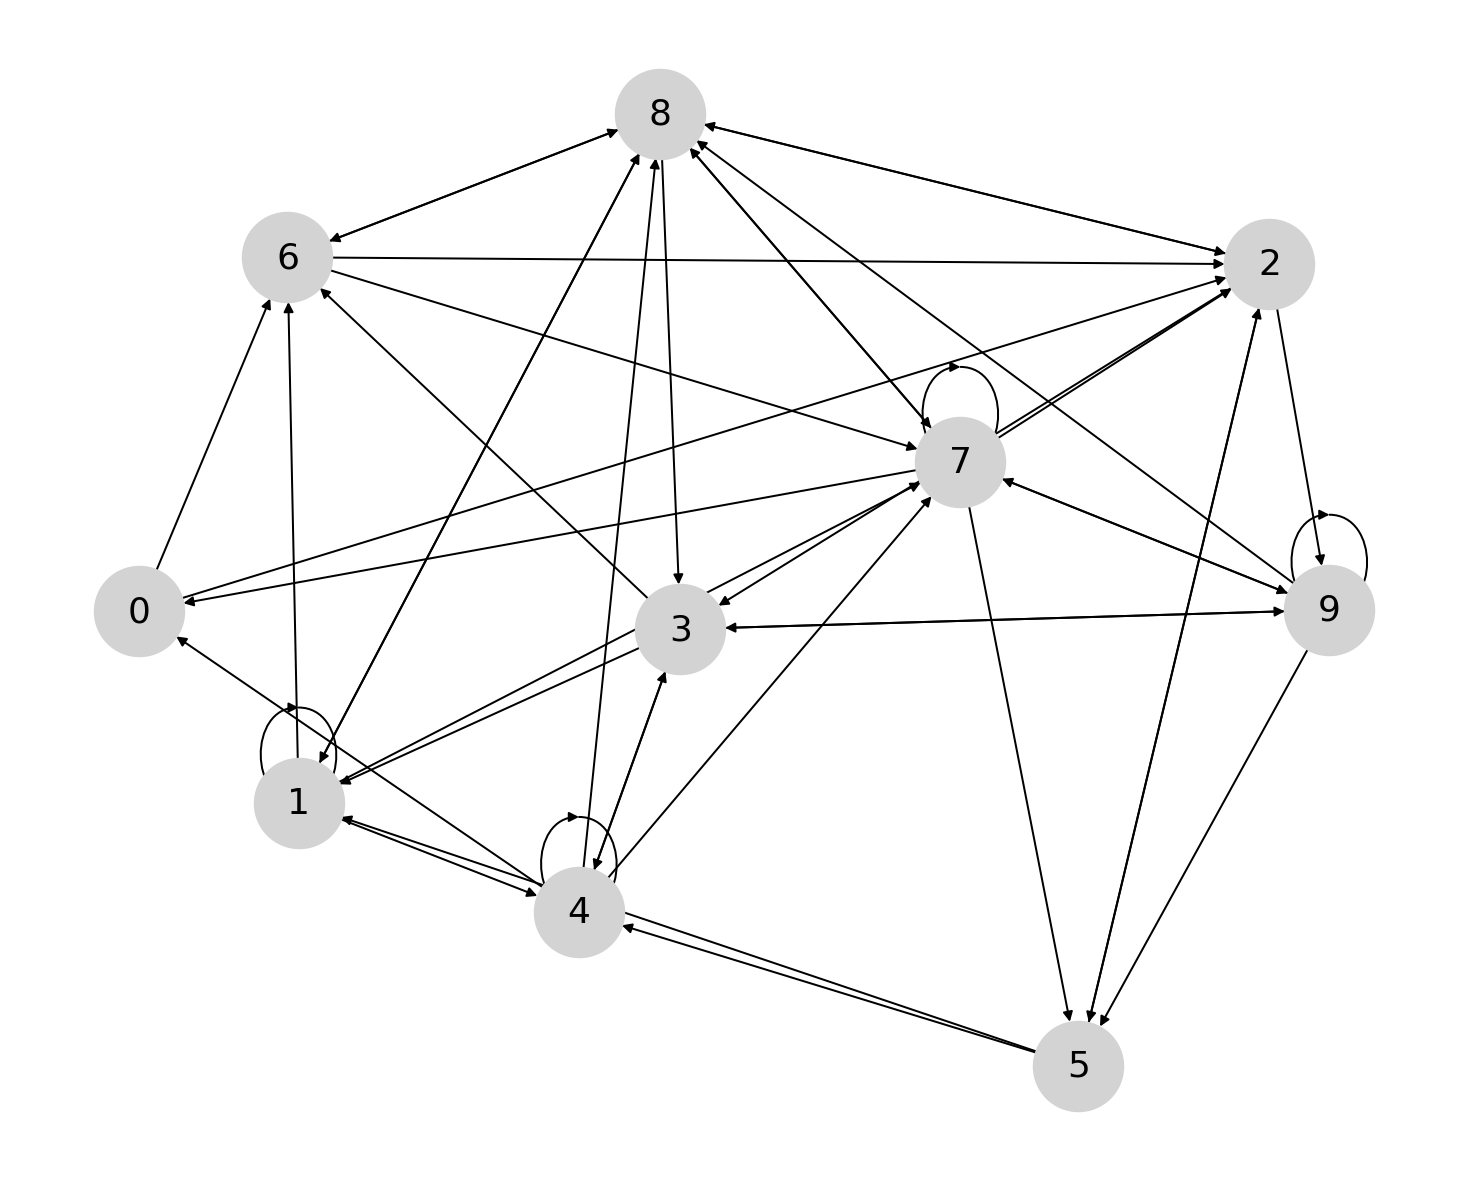

In [22]:
g = dn.DynDiGraph()
time = 0 # initial time

# initial particle locations
p_1 = 1 
p_2 = 2
p_3 = 3
p_4 = 4
p_5 = 5

# dynamically create network
while time < 10:
    
    # set destination of particle
    v_1 = np.random.choice(10, 1)[0]
    v_2 = np.random.choice(10, 1)[0]
    v_3 = np.random.choice(10, 1)[0]
    v_4 = np.random.choice(10, 1)[0]
    v_5 = np.random.choice(10, 1)[0]
    
    # add edges
    g.add_interaction(u=p_1, v=v_1, t=time)
    g.add_interaction(u=p_2, v=v_2, t=time)
    g.add_interaction(u=p_3, v=v_3, t=time)
    g.add_interaction(u=p_4, v=v_4, t=time)
    g.add_interaction(u=p_5, v=v_5, t=time)
    
    # reset particle locations
    p_1 = v_1
    p_2 = v_2
    p_3 = v_3
    p_4 = v_4
    p_5 = v_5
    
    # advance time
    time +=1

nx.draw(g, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

**Problems:**

* No geometry constraint
    * Graph is a topological object in all of these libraries
    * Potential solution: Gurobi
* No velocity/direction implemented
* Run/tumble combined